In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from fleck import Star, generate_spots
import astropy.units as u
from scipy.optimize import fmin_powell, fmin_l_bfgs_b

In [2]:
from batman import TransitModel, TransitParams

p = TransitParams()
p.per = 1.58040464894
p.t0 = 2455320.535733
p.inc = 89.1
p.a = 15.23
p.w = 90
p.ecc = 0
p.u = [0.28]
p.limb_dark = 'linear'
p.rp = 0.013490**0.5

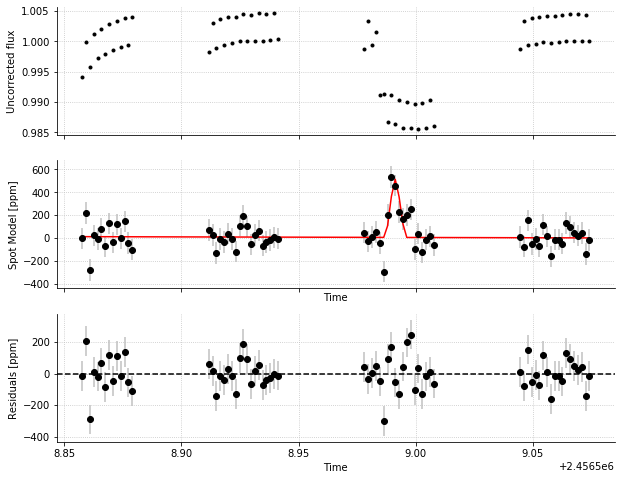

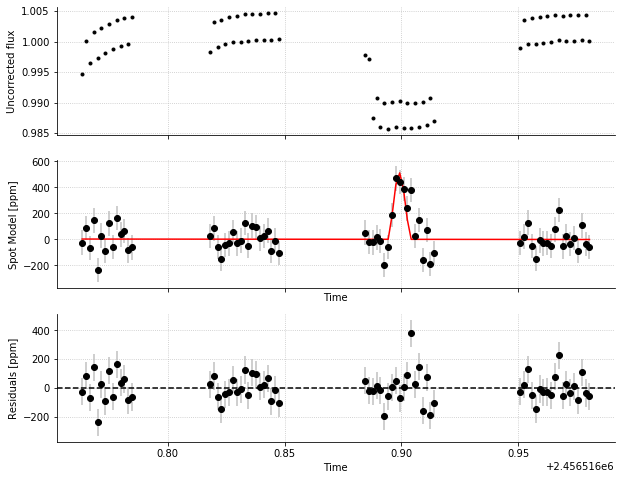

In [3]:
names = ['BJD_TDB', 'flux', 'err', 'visit', 'orbit', 'spatial_scan']
vis12 = Table.read('data/whitelc_vis12.txt', format='ascii', delimiter=' ', 
                   names=names)
vis13 = Table.read('data/whitelc_vis13.txt', format='ascii', delimiter=' ',
                   names=names)

def gauss(p, x): 
    amp, t0, sigma = p
    return amp * np.exp(-0.5 * (x - t0)**2 / sigma**2)

visnum = [12, 13]
detrended_times = []
detrended_phase = []
detrended_flux = []
detrended_errors = []
spotted_flux = []
spot_params = []

initps = [[59, -20], 
          [59, -20]]
bounds = [[0, 90], 
          [-35, 0],
          ]
skip = 4
tau = 4.24e-3
spot_contrast= 0.8
spot_radius = 0.2

for vis, num, initp in zip([vis12, vis13], visnum, initps):

    s1 = (vis['spatial_scan'][skip:] == 0).astype(float)
    s2 = (vis['spatial_scan'][skip:] == 1).astype(float)
    orbit_inds = np.array([i == vis['orbit'][skip:] for i in np.unique(vis['orbit'])]).astype(float)
    times, fluxes, errors = vis['BJD_TDB'].data[skip:], vis['flux'].data[skip:], 1.5 * vis['err'].data[skip:]

    errors /= np.median(fluxes)
    fluxes /= np.median(fluxes)

    transit_model = TransitModel(p, times, supersample_factor=10,
                                 exp_time=times[1]-times[0]).light_curve(p)
    
    t = np.array([(times - times[i.astype(bool)].mean()) * i for i in orbit_inds])
    
    phase = ((times - p.t0) % p.per) / p.per
    phase[phase >= 0.5] -= 1

    mask_center_transit = np.ones_like(times).astype(bool)
    
    Omega_0 = np.diag(errors**2)
    inv_Omega_0 = np.linalg.inv(Omega_0)
    s = Star(spot_contrast, u_ld=[0, 0.28], phases=detrended_phase, rotation_period=125)
    
    def model(theta, include_spot=False):
        spot_lon, spot_lat = theta
        
        # compute spot occultation model    
        lons = [[spot_lon]]*u.deg
        lats = [[spot_lat]]*u.deg
        rads = np.array([[spot_radius]])
        incs = 90*u.deg
        f_spot = s.light_curve(lons, lats, np.array([[0]]), incs, 
                               planet=p, times=times, 
                               fast=True)[:, 0]
        f = s.light_curve(lons, lats, rads, incs, 
                          planet=p, times=times, 
                          fast=True)[:, 0]
        diff_lc = f - f_spot
        diff_lc -= diff_lc.min()
        
        X_nomask = np.vstack([1-np.exp(-t/tau), t, orbit_inds[0:3], 
                              s1, s2, transit_model, diff_lc]).T
        X = X_nomask[mask_center_transit]

        XOX_inv = np.linalg.inv(X.T @ inv_Omega_0 @ X)
        c0 = XOX_inv @ X.T @ inv_Omega_0 @ fluxes[mask_center_transit]
        if not include_spot:
            return X_nomask[:, :-1] @ c0[:-1], diff_lc * c0[-1]
        return X_nomask @ c0
        
    def chi2(p):
        return np.sum((fluxes - model(p))**2 / errors**2)

    # Compute best systematics model
    bestp = fmin_l_bfgs_b(chi2, initp, approx_grad=True, maxls=100,
                          bounds=bounds)[0]
    best_model_nospot, diff_lc = model(bestp)
    best_model_withspot = model(bestp, include_spot=True)
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    ax[0].plot(times, fluxes, '.', color='k')
    ax[0].set_ylabel('Uncorrected flux')
    ax[0].grid(ls=':', color='silver')
    
    ax[1].errorbar(times, 1e6 * (fluxes - best_model_nospot), 1e6 * errors, 
                   fmt='o', color='k', ecolor='silver')

    ax[1].plot(times, 1e6 * diff_lc, color='r')

    ax[1].set_ylabel('Spot Model [ppm]')
    ax[1].set_xlabel('Time')
    ax[1].grid(ls=':', color='silver')    
    
    ax[2].set_ylabel('Residuals [ppm]')
    ax[2].set_xlabel('Time')
    ax[2].grid(ls=':', color='silver')    
    
    ax[2].errorbar(times, 1e6 * (fluxes - best_model_withspot), 1e6 * errors, 
                   fmt='o', color='k', ecolor='silver')
    ax[2].axhline(0, color='k', ls='--')
    
    for axis in ax: 
        for sp in ['right', 'top']: 
            axis.spines[sp].set_visible(False)
    fig.savefig('plots/visit{0}.pdf'.format(num), bbox_inches='tight')

    plt.show()
    spot_params.append(bestp)
    detrended_phase.append(phase)
    detrended_times.append(times)
    detrended_flux.append(fluxes - best_model_withspot)
    spotted_flux.append(fluxes - best_model_nospot)
    detrended_errors.append(errors)

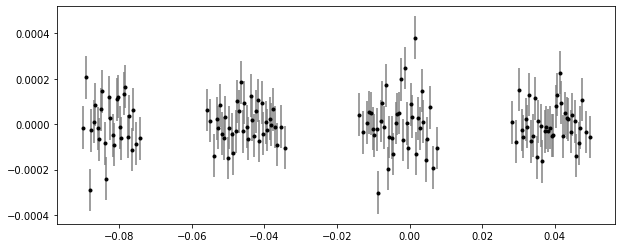

In [5]:
plt.figure(figsize=(10, 4))
for i in range(2):
#     plt.errorbar(detrended_phase[i], spotted_flux[i], detrended_errors[i], 
#                  fmt='.', ecolor='gray', color='k')
    plt.errorbar(detrended_phase[i], detrended_flux[i], detrended_errors[i], 
                 fmt='.', ecolor='gray', color='k')